## TP2 : Classification using Linear & Quadratic Discriminant Analysis

First think of configuring your notebook :

In [851]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from copy import deepcopy #This function is used to create a deep copy from a variable to ensure that we don't lose alter
#the original's value
plt.style.use('ggplot') #Used to give a pretty look to our plots

## Reading synthetic data
Load the training and test data sets |synth_train.txt| and
|synth_test.txt| already used for Knn. Targets belong to {1,2} and entries belong to R^2.
We have 100 training data samples and 200 test samples.

* the 1st column contains the label of the class the sample, 
* columns 2 & 3 contain the coordinates of each sample in 2D.

In [852]:
train = np.loadtxt('synth_train.txt')

test = np.loadtxt('synth_test.txt')

In [853]:
train[:,0]

array([2., 2., 2., 2., 1., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 2.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 1., 2., 2., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 2., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1.])

## Recall about the main steps of discriminant analysis:
* estimation of weights `pi_1` and `pi_2` for each class,
* estimation of empirical means `mu_1` and `mu_2` for each class, 
* estimation of empirical covariance matrices  `sigma_1` and `sigma_2`,
* computation of the common averaged covariance `sigma` (average of intra-class covariances),
* computation of log-probabilities of belonging to each class,
* decision of classification,
* display results.


## TO DO : linear & quadratic discriminant analysis (LDA & QDA)
1. Implement a classifier using LDA of the data set. 
2. Then implement QDA classification.
3. In each case (LDA & QDA) show the decision boundary and
compute the error rate respectively for the training set and the test set. 
4. Compare and comment on your results with LDA and QDA.
5. You may also compare your results to K nearest neighbours.

_Indication 1 : matrices `sigma` are of size 2x2.
More generally, be careful of the sizes of vectors and matrices you
manipulate._

_Indication 2 : to display the regions of decision, you may use:_


### Initialisation of data and first qualitative analysis :

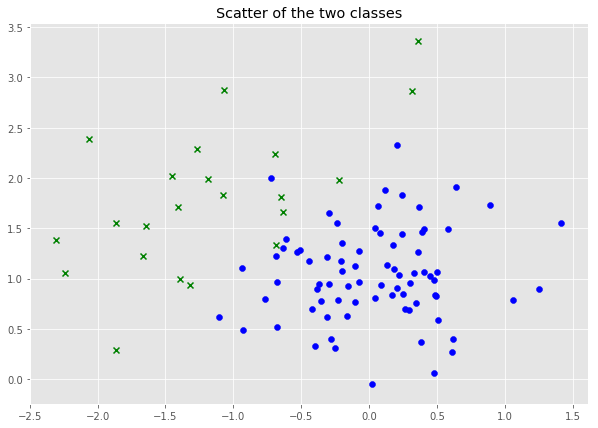

In [854]:
N_1 = len(train[train[:,0]==1])
N_2 = len(train[train[:,0]==2])
train_1 = train[train[:,0]==1]
train_2 = train[train[:,0]==2]

plt.figure(figsize=(10,7))

plt.scatter(train_1[:,1],train_1[:,2],c='g', alpha=1, marker='x')
plt.scatter(train_2[:,1],train_2[:,2],c='b', alpha=1, marker='o')
plt.grid(True)
plt.title("Scatter of the two classes")

plt.show()

### First picture of the data :
- <font color='blue'> Comment on the scatter :</font> Through the scatter we can already speculate that the data is linearly separable, which means that the linear model LDA will be of good use in this classification problem, especially that the train set here does not contain any critical outliers. This being said, it does not exclude an eventual possibility of overfitting depending on new data.

## 1) Implement a classifier using `LDA` of the data set : 

#### <font color="red">Note : In this question, we also show the decision boundary and compute the error rate respectively for the training set and the test set<font>
To do so we are going to unroll the discrimant analysis main steps. In each step we are calculating the parameters of the algorithm in the train set for the illustration purpose, but in the algorithm we will include the computation of those parameters to simplify the test procedure and performance analysis later :

#### <font color='blue'> a) estimation of weights `pi_1` and `pi_2` for each class :</font>

In [855]:
pi_1 = (N_1 / len(train[:,0]))
pi_2 = (N_2 / len(train[:,0]))
print("pi_1 : ", pi_1)
print("pi_2 : ", pi_2)

pi_1 :  0.22
pi_2 :  0.78


#### <font color='blue'> b) estimation of empirical means `mu_1` and `mu_2` for each class : </font>

In [856]:
#given the train set (Input), we compute the means on each class (the output)
def compute_mu(train:np.array):
    feautures_number=train.shape[1]-1
    train_1,train_2=train[train[:,0]==1], train[train[:,0]==2]
    mu_1, mu_2 = np.array([[sum(train_1[:,i])/N_1 for i in range(1,feautures_number+1)]]), np.array([[sum(train_2[:,i])/N_2 for i in range(1,feautures_number+1)]])
    return mu_1, mu_2

mu1, mu2 = compute_mu(train)
print("mu_1 : ", mu1)
print("mu_2 : ", mu2)

mu_1 :  [[-1.18350693  1.78655437]]
mu_2 :  [[0.02868973 1.04424548]]


#### <font color='blue'> c) estimation of empirical covariance matrices  `sigma_1` and `sigma_2` : </font>

In [857]:
#Given the occurence of each class (Ni), its mean (mu_i), the data on this class (train_i)
#We compute the covariance matrix estimator (output) 
#Note one subtlety, which is that in the course we divide by the number of occurences of the class, while in a lot of 
#scientific papers we divide by the same quantity minus 1 (even in the sickit-learn algorithm, something we noted 
#when we loged the covariance estimator of sickit learn algorithms)
def compute_sigma(N_i, mu_i, train_i):
    nbr_features=train_i.shape[1]-1
    sigma_i=np.zeros((nbr_features,nbr_features))
    for i in range(N_i):
        suqared_elt=np.array([[train_i[:,j][i] - mu_i[0,j-1] for j in range(1,nbr_features+1)]])
        sigma_i=np.add(sigma_i,suqared_elt.T.dot(suqared_elt))
    return (1/(N_i-1))*sigma_i

sigma_1=compute_sigma(N_1, mu1, train_1)
sigma_2=compute_sigma(N_2, mu2, train_2)
print("sigma_1 :\n", sigma_1)
print()
print("sigma_2 :\n", sigma_2)

sigma_1 :
 [[0.54124863 0.32258376]
 [0.32258376 0.51088153]]

sigma_2 :
 [[0.24599115 0.01961141]
 [0.01961141 0.21154879]]


#### <font color='blue'> d) computation of `the common averaged covariance sigma` (average of intra-class covariances) : </font>

In [858]:
#Compute the averaged sigma
sigma_avg=np.add(pi_1*sigma_1, pi_2*sigma_2)
print("sigma_avg :\n",sigma_avg)

sigma_avg :
 [[0.3109478  0.08626533]
 [0.08626533 0.277402  ]]


#### <font color='blue'> e) computation of log-probabilities of belonging to each class : </font>
Being only intersted in the class discrimnator : $$argmax_k \; p(C_k/x) = argmax_k \;(\log(\pi_k)-\frac{1}{2} (x-\mu_k)^\top\Sigma^{-1} (x-\mu_k))$$We droped constant arguments on the log-probabilities estimation function because they don't affect the discrimination process 

In [859]:
#This function computate the log-proba on a given data point x for a given class :
def log_proba(pi_k,mu_k, sigma, x:np.array)->float:
    return np.log(pi_k)-(0.5*(x-mu_k).dot(la.inv(sigma).dot((x-mu_k).T)))[0,0]

x=np.array([[10,3]])    
post_p_1=log_proba(pi_1, mu1, sigma_avg, x)
post_p_2=log_proba(pi_2, mu2, sigma_avg, x)

print("Log-proba computed on {x} :".format(x=x),post_p_1)
print("Log-proba computed on {x} :".format(x=x),post_p_2)

Log-proba computed on [[10  3]] : -209.66654065473068
Log-proba computed on [[10  3]] : -161.4218425405328


#### <font color='blue'> f) decision of classification : </font>

We above showed how to compute the main parameters of the LDA algorithm ($\pi, \mu ...$) from a train set. In order to make a generic model of the classifier that fits from any given train set, our `LDA_classifier` will only take the train set to fit the model. Till fitting the model is here only about computing the parameters of the LDA algorithm from the data set, which is not computationnaly tough in our data structure so our classifier will directly take two parameters (`the train set and the test set`) and make the prediction. 

In [860]:
def LDA_classifier(train_data,test_data):
    feautures_number=test_data.shape[1]
    N_1, N_2 = len(train_data[train_data[:,0]==1]), len(train_data[train_data[:,0]==2])
    pi_1, pi_2 = (N_1 / len(train_data[:,0])), (N_2 / len(train_data[:,0]))
    train_1, train_2 = train_data[train_data[:,0]==1], train_data[train_data[:,0]==2]
    mu_1, mu_2 = compute_mu(train_data)
    sigma_1, sigma_2=compute_sigma(N_1, mu_1, train_1), compute_sigma(N_2, mu_2, train_2)
    sigma_avg=np.add(pi_1*sigma_1, pi_2*sigma_2)
    classes_array=np.empty(0)
    for data_point in test_data:
        if log_proba(pi_1,mu_1, sigma_avg, data_point)>=log_proba(pi_2,mu_2, sigma_avg, data_point):
            classes_array=np.append(classes_array, 1)
        else:
            classes_array=np.append(classes_array, 2)
    return classes_array

#### <font color='blue'> g) classification results : </font>

> To comment on the train error and the generalization error we define the error function bellow. It reprsents the fraction of the misclassified input points in data set :

In [861]:
#Takes the test input and the its estimation and calculate the classification error
def misclass_error(y_pred:np.array,y:np.array)->float:
    length=len(y_pred)
    correct_predictions=[y_pred[i] for i in range(length) if y_pred[i]==y[i]]
    error=100-(len(correct_predictions)/length)*100
    return error   

> Highlight the decision boundary between the two classes :

In [862]:
# Given the fact the boundries between the classes is determend by the set of points where the log-proba of the classes
# are approximately equal. Hence, th
def draw_boundry(pi, mu, sigma, test_set, ax, epsillon=0.01):
    min1, min2, max1, max2=min(test[:,1]), min(test[:,2]), max(test[:,1]), max(test[:,2])
    x, y=np.linspace(min1,max1,500), np.linspace(min2,max2,500)
    feat1s, feat2s=[], []
    for feat1 in x:
        for feat2 in y:
            point=np.array([[feat1,feat2]])
            if abs(log_proba(pi[0],mu[0], sigma[0], point)-log_proba(pi[1],mu[1],sigma[1], point))<=epsillon:
                feat1s.append(feat1)
                feat2s.append(feat2)
    ax.scatter(feat1s,feat2s,c='r', alpha=0.5, s=5)
    ax.plot(feat1s,feat2s)

In [863]:
LDA_output_on_train=LDA_classifier(train, train[:,1:3])
print("[ LDA ] The misclassification error on the training set is : "+str(misclass_error(LDA_output_on_train, train[:,0]))+' %')
LDA_output_on_test=LDA_classifier(train, test[:,1:3])
print("[ LDA ] The misclassification error on the test set is : "+str(misclass_error(LDA_output_on_test, test[:,0]))+' %')

[ LDA ] The misclassification error on the training set is : 3.0 %
[ LDA ] The misclassification error on the test set is : 5.5 %


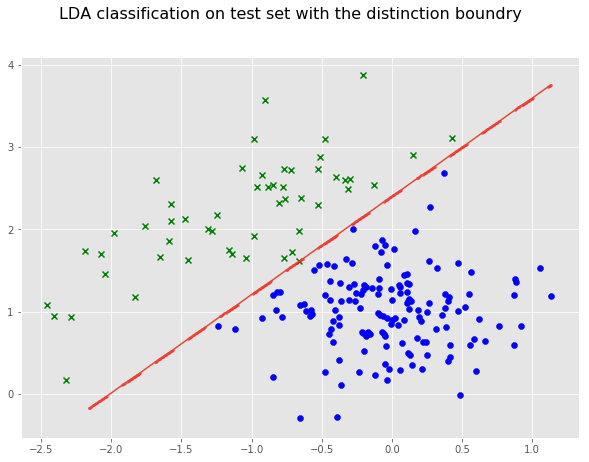

In [864]:
LDA_on_test= np.column_stack((LDA_output_on_test, test[:,1:3]))

LDA_classed_1 = LDA_on_test[LDA_on_test[:,0]==1]
LDA_classed_2 = LDA_on_test[LDA_on_test[:,0]==2]

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(LDA_classed_1[:,1],LDA_classed_1[:,2],c='g', alpha=1, marker='x')
ax.scatter(LDA_classed_2[:,1],LDA_classed_2[:,2],c='b', alpha=1)
ax.grid(True)
fig.suptitle("LDA classification on test set with the distinction boundry", fontsize=16)
draw_boundry([pi_1,pi_2], [mu1,mu2], [sigma_avg,sigma_avg],test, ax)

## 2) Implement `QDA` classification : 

The only parameter to change is the variance associated to the model, by attributing its value for each class throughout the train set. Therfore $\Sigma_1$ for the first class is nothing more than the `sigma_1` already computed and $\Sigma_2$ is `sigma_2` for the second class.

The log_proba defined function won't change because it takes the value of $\Sigma$ as a parameter.

In [865]:
def QDA_classifier(train_data, test_data):
    feautures_number=test_data.shape[1]
    N_1, N_2 = len(train_data[train_data[:,0]==1]), len(train_data[train_data[:,0]==2])
    pi_1, pi_2 = (N_1 / len(train_data[:,0])), (N_2 / len(train_data[:,0]))
    train_1, train_2 = train_data[train_data[:,0]==1], train_data[train_data[:,0]==2]
    mu_1, mu_2 = mu_1, mu_2 = compute_mu(train_data)
    sigma_1, sigma_2=compute_sigma(N_1, mu_1, train_1), compute_sigma(N_2, mu_2, train_2)
    classes_array=np.empty(0)
    for data_point in test_data:
        if log_proba(pi_1,mu_1, sigma_1, data_point)>=log_proba(pi_2,mu_2, sigma_2, data_point):
            classes_array=np.append(classes_array, 1)
        else:
            classes_array=np.append(classes_array, 2)
    return classes_array

In [866]:
QDA_output_on_train=QDA_classifier(train,train[:,1:3])
print("[ QDA ] The misclassification error on the training set is : "+str(misclass_error(QDA_output_on_train, train[:,0]))+' %')
QDA_output_on_test=QDA_classifier(train,test[:,1:3])
print("[ QDA ] The misclassification error on the test set is : "+str(misclass_error(QDA_output_on_test, test[:,0]))+' %')

[ QDA ] The misclassification error on the training set is : 4.0 %
[ QDA ] The misclassification error on the test set is : 4.5 %


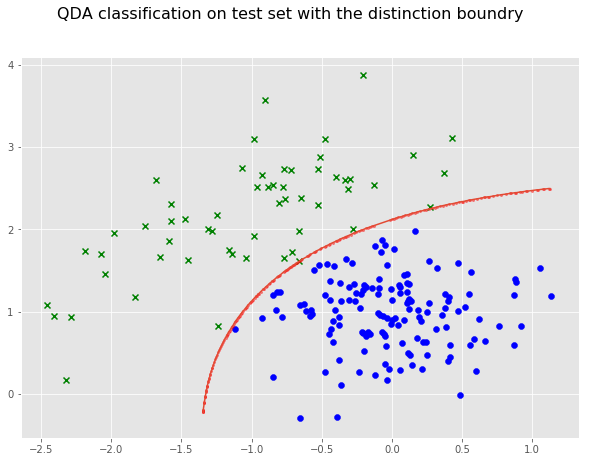

In [867]:
QDA_on_test= np.column_stack((QDA_output_on_test, test[:,1:3]))

QDA_classed_1 = QDA_on_test[QDA_on_test[:,0]==1]
QDA_classed_2 = QDA_on_test[QDA_on_test[:,0]==2]

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(QDA_classed_1[:,1],QDA_classed_1[:,2],c='g', alpha=1, marker='x')
ax.scatter(QDA_classed_2[:,1],QDA_classed_2[:,2],c='b', alpha=1)
ax.grid(True)
fig.suptitle("QDA classification on test set with the distinction boundry", fontsize=16)
draw_boundry([pi_1,pi_2], [mu1,mu2], [sigma_1,sigma_2], test, ax)

## 3. Compare and comment on your results with `LDA` and `QDA`.
 

Throughout the train and test error from the non normalized data we can draw th conclusions :
- <font color="blue">As we expected from the train scatter the train error on LDA is very small, and so it is for QDA too with a little advantage for LDA<font>
- <font color="blue">On the test sample it's quite the same annotation bu with the advantage here for QDA. This does not hep make a final conclusion about the best algorithm on this data set even if we may tend to eventual possibility that the LDA overffited according to the result on the test.<font>

A first reflex we had is to see if the normalization of the data might have an effect on both algorithms performances. So we fitted again, this time on normalized features. See the code and the results `below`.

In [868]:
#This function takes an array of data and normalize its features
def normalize_data(data):
    data_copy=deepcopy(data)
    nbr_features=data_copy.shape[1]-1
    for i in range(1,nbr_features+1):
        data_copy[:,i]=(data_copy[:,i]-np.mean(data_copy[:,i]))/np.std(data_copy[:,i])
    return data_copy

In [869]:
# normalized_train=normalize_data(train)
normalized_test=normalize_data(test)

N_LDA_output_on_train=LDA_classifier(normalized_train, normalized_train[:,1:3])
print("[ LDA ] The misclassification error on the training set is : "+str(misclass_error(N_LDA_output_on_train, normalized_train[:,0]))+' %')
N_LDA_output_on_test=LDA_classifier(normalized_train, normalized_test[:,1:3])
print("[ LDA ] The misclassification error on the test set is : "+str(misclass_error(N_LDA_output_on_test, normalized_test[:,0]))+' %')
print()
N_QDA_output_on_train=QDA_classifier(normalized_train,normalized_train[:,1:3])
print("[ QDA ] The misclassification error on the training set is : "+str(misclass_error(N_QDA_output_on_train, normalized_train[:,0]))+' %')
N_QDA_output_on_test=QDA_classifier(normalized_train,normalized_test[:,1:3])
print("[ QDA ] The misclassification error on the test set is : "+str(misclass_error(N_QDA_output_on_test, normalized_test[:,0]))+' %')

[ LDA ] The misclassification error on the training set is : 3.0 %
[ LDA ] The misclassification error on the test set is : 7.5 %

[ QDA ] The misclassification error on the training set is : 4.0 %
[ QDA ] The misclassification error on the test set is : 5.5 %


The results on normalized data are not any better. Even if we keeped the same training error but the test error stil not appealing. Maybe because the data features are quite on the same scale and so keeping them non normalized is the good reflex qualitatively. 

- <font color="red">We here ask this `question` : when does the normalization of data is no more a good approach we we can not make a statement about a high the difference on the scale of the features ?<font> 
    

    
With this one test on the given data split, we can not have any conclusive conclusions even on the matter about the effeciency of the normalization on this given data set. To overtop this we will use a bootstraping method. 

Note that we are going to bootsrap by sampling with replacement. In litterature, it is a method used to estimate a proprety of the data or any other measurement on it. Studies have shown that it helps minimizing the variance of our models and so for us in this case it will help us make a statement about each classification model and its performance. In our case the measure we want to study is the error of each model.

In each boostrap we will train on the whole sample and test on the unseen data.

**Before doing the bootstrapping we will implement the `K nearest neighbours` to have a more critical view of the LDA and QDA :**

In [870]:
# Results using K-nearest neighbours algorithm of sickit-learn for classification (without scaling) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix  

def KNN_model(n_neighbors, train_set):
    x_train, class_train=train_set[:,1:3], train_set[:,0]
    classifier = KNeighborsClassifier(n_neighbors)  
    classifier.fit(x_train, class_train)
    return classifier

#This simple algorithm will choose the best KNN model (it's k) for a given train_set, by calculating its training error
#This function will be used to compare the best KNN with LDA and QDA when we get to the bootsrapping
#We here estimate that the best k won't exceed a value of 20 neither less than 3 to get far from underfitting
#and overfitting problems 
def choose_best_model(train_set):
    classifier1=KNN_model(3, train)
    train_errors=[]
    for k in range(3,21):
        classifier=KNN_model(k, train_set)
        KNN_model_pred=classifier.predict(train_set[:,1:3])
        train_errors.append(misclass_error(KNN_model_pred, train_set[:,0]))
    indexes=[i+3 for i in range(len(train_errors)) if train_errors[i]==min(train_errors)]
    return indexes[0]
    
best_k=choose_best_model(train)
classifier1=KNN_model(best_k, train)
KNN_model_pred_on_train=classifier1.predict(train[:,1:3])
KNN_model_pred_on_test=classifier1.predict(test[:,1:3])

print("The best number K in the case of the given train set is : K =", best_k)
print("The misclassification error on the train set is : "+str(misclass_error(KNN_model_pred_on_train, train[:,0]))+' %')
print("The misclassification error on the test set is : "+str(misclass_error(KNN_model_pred_on_test, test[:,0]))+' %')

The best number K in the case of the given train set is : K = 3
The misclassification error on the train set is : 3.0 %
The misclassification error on the test set is : 4.5 %


- If we only focus on comparing the LDA and QDA with the KNN algorithm based on this train set we would say that the KNN is as performant as the both of the other algorithms for the good chosen K, with a bit of advantage for the KNN on this data set.

**This is another reason to do the bootsrapping**

In [871]:
from sklearn.utils import resample # Used for bootstrapping, by sampling from the data set
from sklearn.model_selection import train_test_split

In [872]:
#The function below return the test set from a bootsrap sample by taking as a parameter the sample and the original data set
#and returning an array with observations from the origial set that did not occurs on the bootstrap sample
def set_train_test_Sets(bootsrap_sample, origin_data_set):#bootsrap_sample have the same shape as origin_data_set
    data_size=len(bootsrap_sample)
    test_indexes, train_indexes=[], []
    for i in range(data_size):
        occurences_i=[]
        for j in range(data_size):
            if np.equal(origin_data_set[i,:], bootsrap_sample[j,:]).all():
                occurences_i.append(j)
        if len(occurences_i)==0:
            test_indexes.append(i)
        else:
            train_indexes.append(i)
    return np.take(origin_data_set, train_indexes, axis=0), np.take(origin_data_set, test_indexes, axis=0)

Below we define functions to compare the models. Note that we made two functions, which is not optimal, but just to differenciate the bootsrapping on the size of the train and test sets

In [873]:
def compare_models_bigger_train_set(nbr_bootsrap, origin_data):
    origin_data_set=deepcopy(origin_data)
    #Here we bootsrap by sampling with replacement from the whole data set.
    bootsraping_samples=[resample(data,n_samples=300) for i in range(nbr_bootsrap)]
    KNN,LDA,QDA=[],[],[]
    for sample in bootsraping_samples:
        #Note that the bootsraping by replacement splitting is the best according
        #some scientific papers. We might have chosen to use a defined size of split but the results would have shown that 
        #this one is better.
        train_set,test_set=set_train_test_Sets(sample, origin_data_set) #This line is with has size of (train, test)~(65%, 35%)
        best_k=choose_best_model(train_set)
        KNN_classifier=KNN_model(best_k, train_set)
        KNN_model_pred_on_test=KNN_classifier.predict(test_set[:,1:3])
        QDA_output_on_test, LDA_output_on_test=QDA_classifier(train_set,test_set[:,1:3]), LDA_classifier(train_set,test_set[:,1:3])
        KNN.append(misclass_error(KNN_model_pred_on_test, test_set[:,0]))
        QDA.append(misclass_error(QDA_output_on_test, test_set[:,0]))
        LDA.append(misclass_error(LDA_output_on_test, test_set[:,0]))
    return {"KNN":KNN,"LDA":LDA,"QDA":QDA}

In [874]:
# The two lines below assign test and train set. The first one is with a size of (train, test)~(65%, 35%)
#while the second line does the opposite. 
def compare_models_bigger_test_set(nbr_bootsrap, origin_data):
    origin_data_set=deepcopy(origin_data)
    #Here we bootsrap by sampling with replacement from the whole data set.
    bootsraping_samples=[resample(data,n_samples=300) for i in range(nbr_bootsrap)]
    KNN,LDA,QDA=[],[],[]
    for sample in bootsraping_samples:
        test_set,train_set=set_train_test_Sets(sample, origin_data_set) #This line is with has size of (train, test)~(35%, 65%)
        best_k=choose_best_model(train_set)
        KNN_classifier=KNN_model(best_k, train_set)
        KNN_model_pred_on_test=KNN_classifier.predict(test_set[:,1:3])
        QDA_output_on_test, LDA_output_on_test=QDA_classifier(train_set,test_set[:,1:3]), LDA_classifier(train_set,test_set[:,1:3])
        KNN.append(misclass_error(KNN_model_pred_on_test, test_set[:,0]))
        QDA.append(misclass_error(QDA_output_on_test, test_set[:,0]))
        LDA.append(misclass_error(LDA_output_on_test, test_set[:,0]))
    return {"KNN":KNN,"LDA":LDA,"QDA":QDA}

In [1]:
#We here concatenate the original train and set data to have the complete data in order to sample from a bigger set of data
data=np.concatenate((train, test), axis=0)

NameError: name 'np' is not defined

[ LDA ] The mean error on test sets (generalization error) is  22.016610747786814
[ QDA ] The mean error on test sets (generalization error) is  16.058230272842167
[ KNN ] The mean error on test sets (generalization error) is  5.9666816140947345


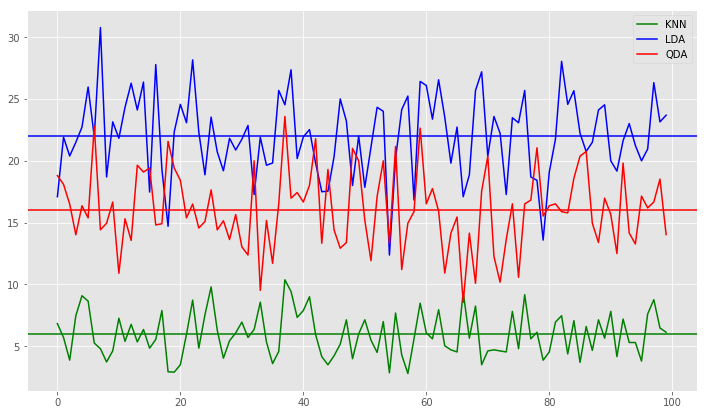

In [832]:
comparison_data=compare_models_bigger_train_set(100, data)

print("[ LDA ] The mean error on test sets (generalization error) is ", np.array(comparison_data["LDA"]).mean())
print("[ QDA ] The mean error on test sets (generalization error) is ", np.array(comparison_data["QDA"]).mean())
print("[ KNN ] The mean error on test sets (generalization error) is ", np.array(comparison_data["KNN"]).mean())


fig_com, ax_com=plt.subplots(figsize=(12,7))
ax_com.plot(comparison_data["KNN"], color='green', label="KNN")
ax_com.axhline(y=np.array(comparison_data["KNN"]).mean(), color='green')
ax_com.plot(comparison_data["LDA"], color='blue',label="LDA")
ax_com.axhline(y=np.array(comparison_data["LDA"]).mean(), color='blue')
ax_com.plot(comparison_data["QDA"], color='red',label="QDA")
ax_com.axhline(y=np.array(comparison_data["QDA"]).mean(), color='red')
ax_com.legend()

- For a bootsrapping method with a big train set (~65%) the LDA and QDA algorithms overfits and KNN (with the best k) has less generalization error.
- QDA even having a bad generalization error still better than LDA. 
- The bad performance of LDA and QDA might be due to the concentration of both classes around the boundries especially with the big training set helping the overfiting of the models.  

[ LDA ] The mean error on test sets (generalization error) is  11.096755714793925
[ QDA ] The mean error on test sets (generalization error) is  5.889168814140215
[ KNN ] The mean error on test sets (generalization error) is  6.487260847035412


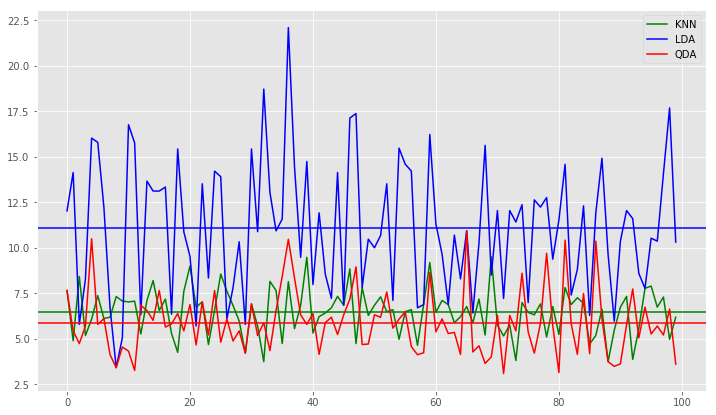

In [837]:
comparison_data=compare_models_bigger_test_set(100, data)

print("[ LDA ] The mean error on test sets (generalization error) is ", np.array(comparison_data["LDA"]).mean())
print("[ QDA ] The mean error on test sets (generalization error) is ", np.array(comparison_data["QDA"]).mean())
print("[ KNN ] The mean error on test sets (generalization error) is ", np.array(comparison_data["KNN"]).mean())


fig_com, ax_com=plt.subplots(figsize=(12,7))
ax_com.plot(comparison_data["KNN"], color='green', label="KNN")
ax_com.axhline(y=np.array(comparison_data["KNN"]).mean(), color='green')
ax_com.plot(comparison_data["LDA"], color='blue',label="LDA")
ax_com.axhline(y=np.array(comparison_data["LDA"]).mean(), color='blue')
ax_com.plot(comparison_data["QDA"], color='red',label="QDA")
ax_com.axhline(y=np.array(comparison_data["QDA"]).mean(), color='red')
ax_com.legend()

- Even with a less sized training set the LDA algorithm still have a poo averaged error of generalization, even if it tends to be low for well chosen sets of training and test. This is, as we said, maybe beacause of the overfiting around the boundry area.
- QDA has the best performance among the three algorithms. It's non linear boundries are less sensitive to the distribution of the data, which might have resolved the problem of overfiting thanks to the use of less training data.   

## 4. Implementation with Sickit-learn :

- __LDA using sklearn__

In [838]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [839]:
lda = LinearDiscriminantAnalysis(solver='svd')

In [840]:
sklearn_LDA_output_on_train = lda.fit(train[:,[1,2]], train[:,0]).predict(train[:,[1,2]])
print("The misclassification error on the training set is : "+str(misclass_error(sklearn_LDA_output_on_train, train[:,0]))+' %')
sklearn_LDA_output_on_test = lda.fit(test[:,[1,2]], test[:,0]).predict(test[:,[1,2]])
print("The misclassification error on the test set is : "+str(misclass_error(sklearn_LDA_output_on_test, test[:,0]))+' %')

The misclassification error on the training set is : 3.0 %
The misclassification error on the test set is : 5.5 %


- We exactly reproduced the same results as for the LDA algorithm we implemented above. 

- __QDA using sklearn__

In [559]:
qda = QuadraticDiscriminantAnalysis()

In [560]:
fited_QDA=qda.fit(train[:,[1,2]], train[:,0])
sklearn_QDA_output_on_train = fited_QDA.predict(train[:,[1,2]])
print("The misclassification error on the training set is : "+str(misclass_error(sklearn_QDA_output_on_train, train[:,0]))+' %')
sklearn_QDA_output_on_test = fited_QDA.predict(test[:,[1,2]])
print("The misclassification error on the test set is : "+str(misclass_error(sklearn_QDA_output_on_test, test[:,0]))+' %')

The misclassification error on the training set is : 5.0 %
The misclassification error on the test set is : 5.0 %


- There is a slightly diffrenece from the QDA algorithm we implemented above, even after using the same formula of the covariance estimator. 

## 5. To see if there might be a non linear dependancy of the classification target on data, we add the two features moomials as features : $x_1^{2}, x_1x_2, x_2^{2}$

- <font color='blue'>A legitime hypothesis to justify the bad performance of the LDA on generalization after we used the bootsrappoing approach is to see if the features non linear interactions might have an effect on the data distribution and so on the classification <font>

In [843]:
# Takes an array of data and adds the monomials (containing the target in the first column)
def add_monomials(data):
    x1x1=np.array([np.multiply(data[:,1],data[:,1])])
    x1x2=np.array([np.multiply(data[:,1],data[:,2])])
    x2x2=np.array([np.multiply(data[:,2],data[:,2])])
    new_data=np.hstack((data, x1x1.T))
    new_data=np.hstack((new_data, x1x2.T))
    new_data=np.hstack((new_data, x2x2.T))
    return new_data

In [844]:
new_train=add_monomials(train)
new_test=add_monomials(test)

LDA_train=LDA_classifier(new_train,new_train[:,1:6])
print("[ LDA ] The misclassification error on the training set is : "+str(misclass_error(LDA_train, new_train[:,0]))+' %')
LDA_test=LDA_classifier(new_train,new_test[:,1:6])
print("[ LDA ] The misclassification error on the test set is : "+str(misclass_error(LDA_test, new_test[:,0]))+' %')
print()
QDA_train=QDA_classifier(new_train,new_train[:,1:6])
print("[ QDA ] The misclassification error on the training set is : "+str(misclass_error(QDA_train, new_train[:,0]))+' %')
QDA_test=QDA_classifier(new_train,new_test[:,1:6])
print("[ QDA ] The misclassification error on the test set is : "+str(misclass_error(QDA_test, new_test[:,0]))+' %')

[ LDA ] The misclassification error on the training set is : 6.0 %
[ LDA ] The misclassification error on the test set is : 5.5 %

[ QDA ] The misclassification error on the training set is : 4.0 %
[ QDA ] The misclassification error on the test set is : 5.0 %


**The results on the new features are quit appealing but we didn't have enough time to test the bootsrapping on this new structure of data.**

We after tried to draw the boundries by making the projection of the 5-dimentions features on a 2d plan, but the fact that it is computationnaly hard (in terme of runtime). We can not get to make a good estimation of the boundry. 

Below you will see that we made an example of a 5d grid with size of 50*50*10*10*10 (for example from 50*50*50*10*10 the runtime is already booming). This makes that the figure we got of the boundry projection is non reprentitive for the example we did.

In [846]:
def draw_boundry(pi, mu, sigma, test_set, ax, epsillon=0.01):
    min1, min2, max1, max2=min(test_set[:,1]), min(test_set[:,2]), max(test_set[:,1]), max(test_set[:,2])
    min3, min4, max3, max4=min(test_set[:,3]), min(test_set[:,4]), max(test_set[:,3]), max(test_set[:,4])
    min5, max5 = min(test_set[:,5]), max(test_set[:,5])
    x1, x2, x3, x4, x5=np.linspace(min1,max1,50), np.linspace(min2,max2,50), np.linspace(min3,max3,10), np.linspace(min4,max4,10), np.linspace(min5,max5,10)
    feat1s, feat2s, feat3s, feat4s, feat5s=[], [], [], [], []
    for feat1 in x1:
        for feat2 in x2:
            for feat3 in x3:
                for feat4 in x4:
                    for feat5 in x5:
                        point=np.array([[feat1, feat2, feat3, feat4, feat5]])
                        if abs(log_proba(pi[0],mu[0], sigma[0], point)-log_proba(pi[1],mu[1],sigma[1], point))<=epsillon:
                            feat1s.append(feat1)
                            feat2s.append(feat2)
    ax.scatter(feat1s,feat2s,c='r', alpha=0.5, s=5)
    ax.plot(feat1s,feat2s)

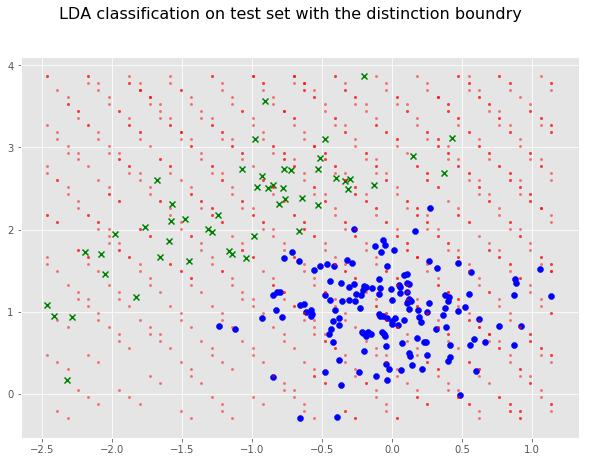

In [850]:
train_1=new_train[new_train[:,0]==1]
train_2=new_train[new_train[:,0]==2]

LDA_test= np.column_stack((LDA_test, new_test[:,1:6]))

new_LDA_classed_1 = LDA_test[LDA_test[:,0]==1]
new_LDA_classed_2 = LDA_test[LDA_test[:,0]==2]

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(new_LDA_classed_1[:,1],new_LDA_classed_1[:,2],c='g', alpha=1, marker='x')
ax.scatter(new_LDA_classed_2[:,1],new_LDA_classed_2[:,2],c='b', alpha=1)
ax.grid(True)
fig.suptitle("LDA classification on test set with the distinction boundry", fontsize=16)

mu_1, mu_2 = compute_mu(new_train)
sigma_1=compute_sigma(N_1, mu_1, train_1)
sigma_2=compute_sigma(N_2, mu_2, train_2)
sigma_avg=np.add(pi_1*sigma_1, pi_2*sigma_2)

draw_boundry([pi_1,pi_2], [mu_1,mu_2], [sigma_avg,sigma_avg],new_test, ax)